In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle
from tqdm import trange
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Load mm object from the file
#filename = "morphmodel.pkl"
#filename = "2dmorphmodel400.pkl"
#with open(filename, "rb") as file:


#    mm = pickle.load(file)

In [2]:
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5", m_min = 8)


File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                    
}



In [5]:
import joblib

In [14]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
import pickle

class mPCA():
    '''Class to perform a PCA on the data.
    
    This class is a wrapper around the sklearn PCA class. It allows to perform a PCA on the data loaded by the DataLoader class.
    
    Parameters:
    -----------
    data : DataLoader
        The data to perform the PCA on. The data must be an instance of DataLoader.
    particle_type : str, optional
        The particle type on which to apply the PCA. If None, the first particle type in the dataset is used.
    norm_function : function, optional
        The function to use to normalize the data before applying the PCA. If None, no normalization is applied.
    norm_function_kwargs : dict, optional
        The keyword arguments to pass to the normalization function.
    mask : np.ndarray, optional
        The mask to apply to the data before applying the PCA. If None, no mask is applied.
    dim : int, optional
        The dimension of the data. If 2, the data is assumed to be 2D. If 3, the data is assumed to be 3D.

    Examples:
    ---------
    >>> data = DataLoader("data.hdf5")
    >>> pca = mPCA(data, particle_type = "stars",dim=2)
    >>> pca.fit()
    >>> eigengalaxies = pca.get_eigengalaxies()
    '''
    
    def _identity(self, x, **kwargs):
        '''Identity function
        
        Used as default if no normalization function is specified.
        '''
        return x
    
    def __init__(self,data, particle_type = None, norm_function = None, norm_function_kwargs=None, mask = None, dim=2):
        # Check if data is instance of DataLoader
        if not isinstance(data, DataLoader):
            raise ValueError("data must be an instance of DataLoader")
        
        # Set the particle type on which to apply the PCA (TODO maybe add option to apply PCA on multiple particle types)
        if particle_type is None:
           # Check if data has multiple particle types
            if len(data._particles_keys) > 1:
                raise ValueError("PCA can only be applied to a single particle type. Please select a single particle type when initializing the PCA object.")
            else:
                # Set the particle type to the only particle type in the dataset
                self.particle_type = data._particles_keys[0]
        else:
            #Check if the particle type is valid
            if particle_type not in data._particles_keys:
                raise ValueError(f"Particle type {particle_type} not found. Valid particle types are: {data._particles_keys}")
            else:
                self.particle_type = particle_type
                
        # Check if mask is set
        if mask is None:
            self.mask = np.ones(data.get_attribute("mass").shape[0]).astype(bool)
        else: 
            self.mask = mask
        
        self.data = data
        self._dim = "dim2" if dim == 2 else "dim3"
        self._norm_function = norm_function if norm_function is not None else self._identity # Set the normalization function to the identity function if no normalization function is specified
        self._norm_function_kwargs = norm_function_kwargs
        self._IMG_ORDER = self.data._image_fields[self.particle_type][self._dim]
        self._IMG_SHAPE = self.data.get_image(self.particle_type, self.data._image_fields[self.particle_type][self._dim][0], index = 0, dim = dim).shape
        # Initialize the datamatrix to of shape (n_galaxies, 0)
        
        self.datamatrix = np.zeros((data.get_attribute("mass").shape[0], len(self._IMG_ORDER) * np.prod(self._IMG_SHAPE))) 

        # Create datamatrix
        self._create_datamatrix(self._dim)
        
        #Get the image shape of one galaxy image
        

            
   
    def _create_datamatrix(self, dim):
        # same as before
        n_jobs = -1  # Use all cores
        for i, field in enumerate(self._IMG_ORDER):
            # Get the image of the specified particle type and field
            image = self.data.get_image(self.particle_type, field, dim = dim)
            norm_params = self._norm_function_kwargs[field] if field in self._norm_function_kwargs.keys() else {}
            # Normalize the images in parallel
            images_normalized = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(self._norm_function)(img, **norm_params) for img in image)
            # Flatten the images
            images_flattened = np.array([img.flatten() for img in images_normalized])
            # Insert the flattened images into the correct place in the datamatrix
            
            self.datamatrix[:, i*np.prod(self._IMG_SHAPE):(i+1)*np.prod(self._IMG_SHAPE)] = images_flattened
            
        
        
    def fit(self, n_components=None, show_results = True,random_sample_ratio = None, **kwargs):
        '''Fit the PCA to the datamatrix
        
        This function fits the PCA to the datamatrix. The scores, eigengalaxies and inverse_transformed_datamatrix are calculated and stored as attributes of the PCA object.
        
        Parameters:
        -----------
        n_components : int, optional
            Number of components to keep. If None, all components are kept.
        show_results : bool, optional
            If True, the results of the PCA are shown.
        random_sample_ratio : float, optional
            If specified, a random sample of the datamatrix is used to fit the PCA. This is useful when the datamatrix is too large to fit in memory,
            or to see if the results of the PCA are consistent when using a random sample of the datamatrix.
            The random_sample_ratio specifies the ratio of the datamatrix that is used to fit the PCA. For example, if random_sample_ratio = 0.1, 10% of the datamatrix is used to fit the PCA.
        **kwargs : dict, optional
            Keyword arguments to pass to the sklearn PCA object.
        '''
        self.pca = PCA(n_components=n_components, **kwargs)
        
        if random_sample_ratio is not None:
            # Get the number of galaxies that are used to fit the PCA
            n_galaxies = int(self.datamatrix.shape[0]*random_sample_ratio)
            # Get a random sample of the datamatrix
            random_sample = np.random.choice(self.datamatrix.shape[0],size= n_galaxies, replace=False)
            self.datamatrix = self.datamatrix[random_sample]
            self.mask = self.mask[random_sample]
        
        self.scores = self.pca.fit_transform(self.datamatrix)
        self.eigengalaxies = self.pca.components_.reshape(self.pca.components_.shape[0],len(self._IMG_ORDER), *self._IMG_SHAPE)
        self.inverse_transformed_datamatrix = self.pca.inverse_transform(self.scores)
        if show_results:
            self.show_results()
            
    def show_results(self, cmap ="gray", cmap_eigen = "RdBu_r", font_size_eigen=35):
        '''Show the results of the PCA'''
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(self.pca.explained_variance_ratio_)
        ax[0].set_xlabel("Component")
        ax[0].set_ylabel("Explained variance ratio")
        ax[1].plot(np.cumsum(self.pca.explained_variance_ratio_))
        ax[1].set_xlabel("Component")
        ax[1].set_ylabel("Cumulative explained variance ratio")
        plt.show()
        
        field_length = len(self._IMG_ORDER) 
        
        
        # Check if the image is 2D 
        if self._dim != "dim2":
            return
        #Loop over different image fields
        for index,field in enumerate(self._IMG_ORDER):
            self.show_eigengalaxies(field=field, cmap=cmap_eigen, font_size = font_size_eigen)  
        #Calculate residue of random galaxy
        self.compare()
    def show_eigengalaxies(self,field="GFM_Metallicity", cmap="RdBu_r", font_size = 25, save_path=None):
        index = self._IMG_ORDER.index(field)
        eigen = self.get_eigengalaxies()[:, index]
        mean = self.get_means()[index]
        # Insert mean to beginning of eigen
        eigen = np.insert(eigen, 0, mean, axis=0)
        n_eigen = len(eigen) 
        
        # Calculate the optimal grid layout
        n_rows = int(np.ceil(np.sqrt(n_eigen)))
        n_cols = int(np.ceil(n_eigen / n_rows))
        
        figsize = (n_cols * 4, n_rows * 4)
        
        # Create the subplots using gridspec
        fig = plt.figure(figsize=figsize)
        width_ratios = [1] * n_cols + [0.5]
        gs = GridSpec(n_rows, n_cols+1, figure=fig,width_ratios=width_ratios)
        
        # Plot the eigengalaxies
        for i in range(n_eigen):
            ax = fig.add_subplot(gs[i])
            if i == 0:
                ax.set_title("Mean", fontsize=font_size)
            else:
                ax.set_title(i, fontsize=font_size)
            im = ax.imshow(eigen[i], cmap=cmap)
            ax.axis('off')
        
        # Add a colorbar using gridspec
        cbar_ax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar.set_label(field, fontsize=font_size)
        cbar.ax.tick_params(labelsize=font_size)
        
        # Adjust spacing between subplots
        fig.tight_layout()
        if save_path is not None:
            plt.savefig(save_path,dpi = 300)
        # Display the plot
        plt.show()        
    def compare(self, index = None, cmap= "gray", savepath = None, show = True,n_eigen = None):
        '''Compare a galaxy with its reconstruction
        
        This function compares a galaxy with its reconstruction. If no index is specified, a random galaxy is chosen.
        
        Parameters:
        -----------
        index : int, optional
            Index of the galaxy to compare. If None, a random galaxy is chosen.
        '''
        field_length = len(self._IMG_ORDER)
        #Calculate residue of random galaxy
        if index is None:
            randomind = np.random.randint(0, self.datamatrix.shape[0])
        else:
            randomind = index

        og = self.datamatrix[randomind].reshape(field_length, *self._IMG_SHAPE)
        if n_eigen is not None:
            scores = self.scores[randomind][:n_eigen]
            n_eigengalaxies = self.eigengalaxies[:n_eigen].reshape(n_eigen, field_length**self._IMG_SHAPE)
            means = self.get_means().reshape(field_length, *self._IMG_SHAPE)
            reconstructed = np.dot(scores, n_eigengalaxies) + means
            reconstructed = reconstructed.reshape(field_length, *self._IMG_SHAPE)
        else:
            reconstructed = self.inverse_transformed_datamatrix[randomind].reshape(field_length, *self._IMG_SHAPE)
        residue = og - reconstructed
        residue_min = np.min(residue) # for colorbar
        residue_max = np.max(residue) # for colorbar
        fig = plt.figure(figsize=(15, 15))
        gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 0.1])  # Adjust width ratios to accommodate the colorbar

        for i in range(3):
            ax1 = fig.add_subplot(gs[i, 0])
            ax1.imshow(og[i], cmap=cmap)
            ax1.set_title(f"Original: {self._IMG_ORDER[i]}")
            ax1.axis("off")

            ax2 = fig.add_subplot(gs[i, 1])
            ax2.imshow(reconstructed[i], cmap=cmap)
            ax2.set_title(f"Reconstructed: {self._IMG_ORDER[i]}")
            ax2.axis("off")

            ax3 = fig.add_subplot(gs[i, 2])
            im = ax3.imshow(residue[i], cmap="coolwarm", vmin=residue_min, vmax=residue_max)
            ax3.set_title(f"Residue")
            ax3.axis("off")

        # Add a single colorbar on the right side
        cax = fig.add_subplot(gs[:, 3])
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("Residue", fontsize=12)
        #fig.suptitle(f"Reconstruction of Galaxy {randomind}")
        plt.tight_layout()
        
        if savepath is not None:
            plt.savefig(savepath, dpi=300)
        if show: plt.show()

            
    def get_eigengalaxies(self):
        '''Return the eigengalaxies'''
        return self.eigengalaxies
    
    def get_means(self):
        '''Return the mean galaxy'''
        return self.pca.mean_.reshape(len(self._IMG_ORDER), *self._IMG_SHAPE)
    
    def project(self, image):
        '''Project an image onto the eigengalaxies
        
        This function projects an image onto the eigengalaxies. The scores are returned.
        
        Parameters:
        -----------
        image : np.ndarray
            Image to project
        '''
        return self.pca.transform(image.reshape(1, -1))
    
    def reconstruct(self, scores):
        '''Reconstruct an image from the scores
        
        This function reconstructs an image from the scores.
        
        Parameters:
        -----------
        scores : np.ndarray
            Scores to reconstruct
        '''
        return self.pca.inverse_transform(scores).reshape(len(self._IMG_ORDER), *self._IMG_SHAPE)
    
    
    def get_scores(self):
        '''Return the scores'''
        return self.scores
    
    def get_images(self, index = None):
        '''Return a galaxy
        
        This function returns the images in the calculated maps. If no index is specified, the images of all galaxies are returned.        
        Parameters:
        -----------
        index : int, optional
            Index of the galaxy images to return. If None, the whole data matrix is returned.
            
        Returns:
        --------
        np.ndarray
            Image of one galaxy or whole datamatrix. Shape depends on the index. If index is None, the shape is (n_galaxies, n_fields, *img_shape), 
            otherwise (n_fields, *img_shape)
        '''
        if index is None:
            return self.datamatrix.reshape(len(self.datamatrix),len(self._IMG_ORDER), *self._IMG_SHAPE)
        else:
            return self.datamatrix[index].reshape(len(self._IMG_ORDER), *self._IMG_SHAPE)
        
    def save(self, path):
        '''Save the PCA
        
        This function saves the object to a pickle file.
        
        Parameters:
        -----------
        path : str
            Path to save the PCA to
        '''
        with open(path, "wb") as f:
            pickle.dump(self, f)

In [15]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 3)

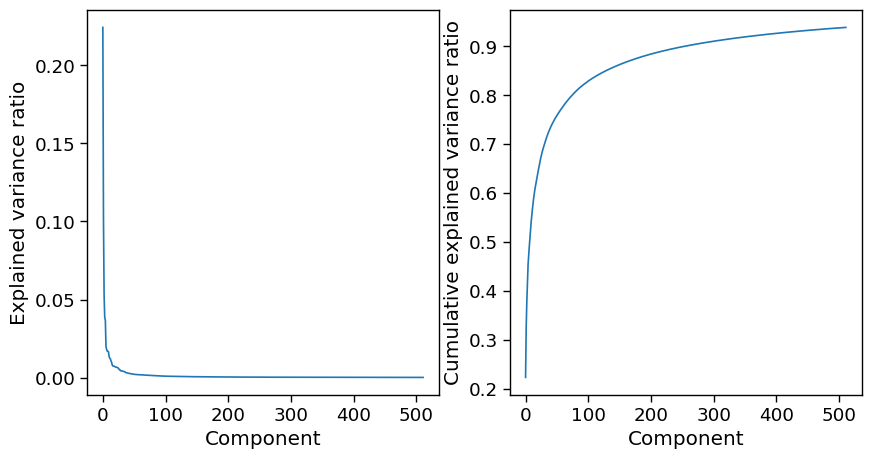

In [16]:
mm.fit(512)

In [17]:
mm.save("3dmorphmodel512.pkl")